# SHAP-Style Plots  Documentation

`scikit-explain` supports the [SHAP package](https://github.com/slundberg/shap), which breaks down individual ML predictions into a series of feature attributions.

In [5]:
import sys, os 
sys.path.append(os.path.dirname(os.getcwd()))

In [6]:
import skexplain
from skexplain.common.importance_utils import to_skexplain_importance
import plotting_config
import numpy as np 
import shap

### Loading the training data and pre-fit models 


In [7]:
estimators = skexplain.load_models()
X,y = skexplain.load_data()

In [8]:
# X_subset is the set of examples we want to get SHAP values for.
random_state = np.random.RandomState(42)

ind = random_state.choice(len(X), size=100, replace=False)
X_subset = X.iloc[ind]
y_subset = y[ind]
X_subset.reset_index(inplace=True, drop=True)

explainer = skexplain.ExplainToolkit(estimators, X=X_subset,)

In [9]:
ind = np.random.RandomState(42).choice(len(X), size=5000, replace=False)
X_ = X.iloc[ind]
X_.reset_index(inplace=True, drop=True)

## Compute the SHAP Values 

When computing SHAP values, the user has a couple options (passed in as ``shap_kwargs``). First, we need to declare the ``masker``. In this example, we are using a built-in method from the [SHAP python package](https://shap.readthedocs.io/en/latest/generated/shap.maskers.Partition.html#shap.maskers.Partition). We could also pass in a background dataset rather a masker (e.g., masker = shap.sample(X, 100).reset_index(drop=True)). Second, we can declare the SHAP algorithm we want to use. By default, we set ``algorithm = "auto"`` and the SHAP package will determine the best algorithm. If we use the Partition masker, I've found that it will default to the ``Exact`` and otherwise it will try to use ``Permutation`` (note there are other options, but for different model types).

In [6]:
#results = explainer.shap(shap_kwargs={'masker' : 
#                                      shap.maskers.Partition(X, max_samples=100, clustering="correlation"), 
#                                     'algorithm' : 'permutation'})
#explainer.save('shap_values.nc', data=results)

In [10]:
results = explainer.load('shap_values.nc')

## Summary Plot

Once we compute the SHAP values for a large number of examples, we can evaluate different patterns. For example, in the plot below, SHAP values are ranked by their absolute sum. Additionally, the SHAP values are color-coded by their normalized magnitude where red indicates a higher predictor value while blue indicates a lower predictor value. In this case, surface temperature ($T_{sfc}$) had the largest absolute sum and lower values increases the probability of freezing road surface temperatures. 



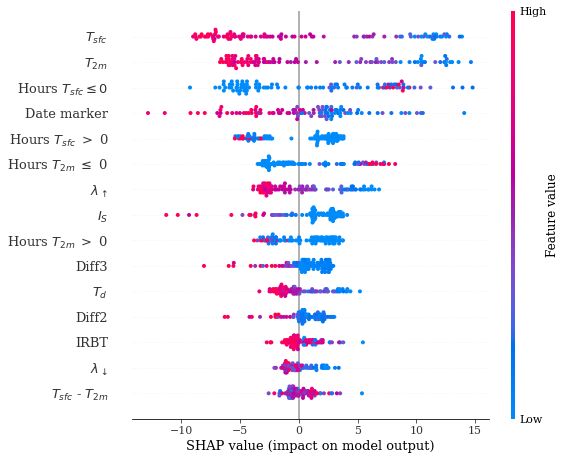

In [8]:
#shap_values, bias = results['Random Forest']
explainer.plot_shap(
                    plot_type = 'summary',
                    shap_values=results,
                    estimator_name = 'Random Forest',
                    display_feature_names=plotting_config.display_feature_names,
)                           

Instead of this plot, we can evaluate the SHAP-based ranking with the bar-style plot used in skexplain. 

(<Figure size 900x750 with 3 Axes>, <AxesSubplot:>)

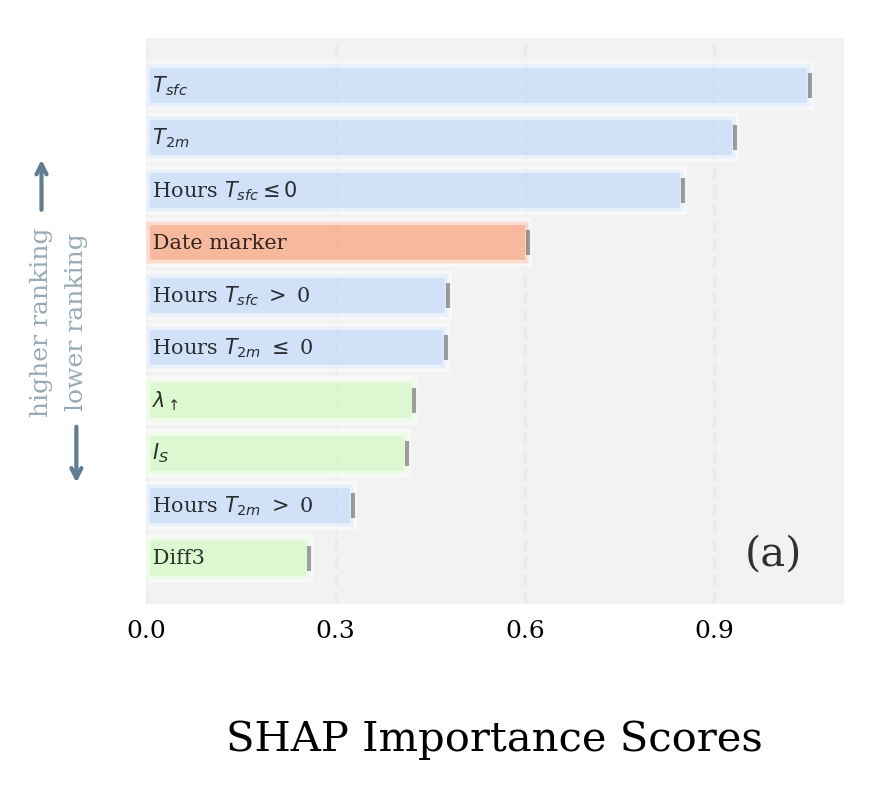

In [11]:
# Convert the shap values to importance scores for plotting.
# For SHAP values, we can use the 'shap_sum' or 'shap_std' methods available
# in to_skexplain_importance. 

shap_values = results['shap_values__Random Forest'].values

data = to_skexplain_importance(shap_values, estimator_name='Random Forest', 
                               feature_names=X.columns, method='shap_sum')

explainer.plot_importance(data=data,
                          panels = [('shap_sum', 'Random Forest')],
                          display_feature_names=plotting_config.display_feature_names,
                          feature_colors=plotting_config.color_dict,
                          method='shap')

### Dependence Plot

SHAP values can also be displayed similar to ALE/PD curve where the values are presented as a function of the predictor value. For this plots, we can also include `histdata`, which is a combination of `X` and `y`. For classification problems, the user can provide the name of the target variable and the background histogram will be color-coded for the different classes. Lastly, each dot is color coded by the value of the feature that approximately interacts with the feature being plotted. 


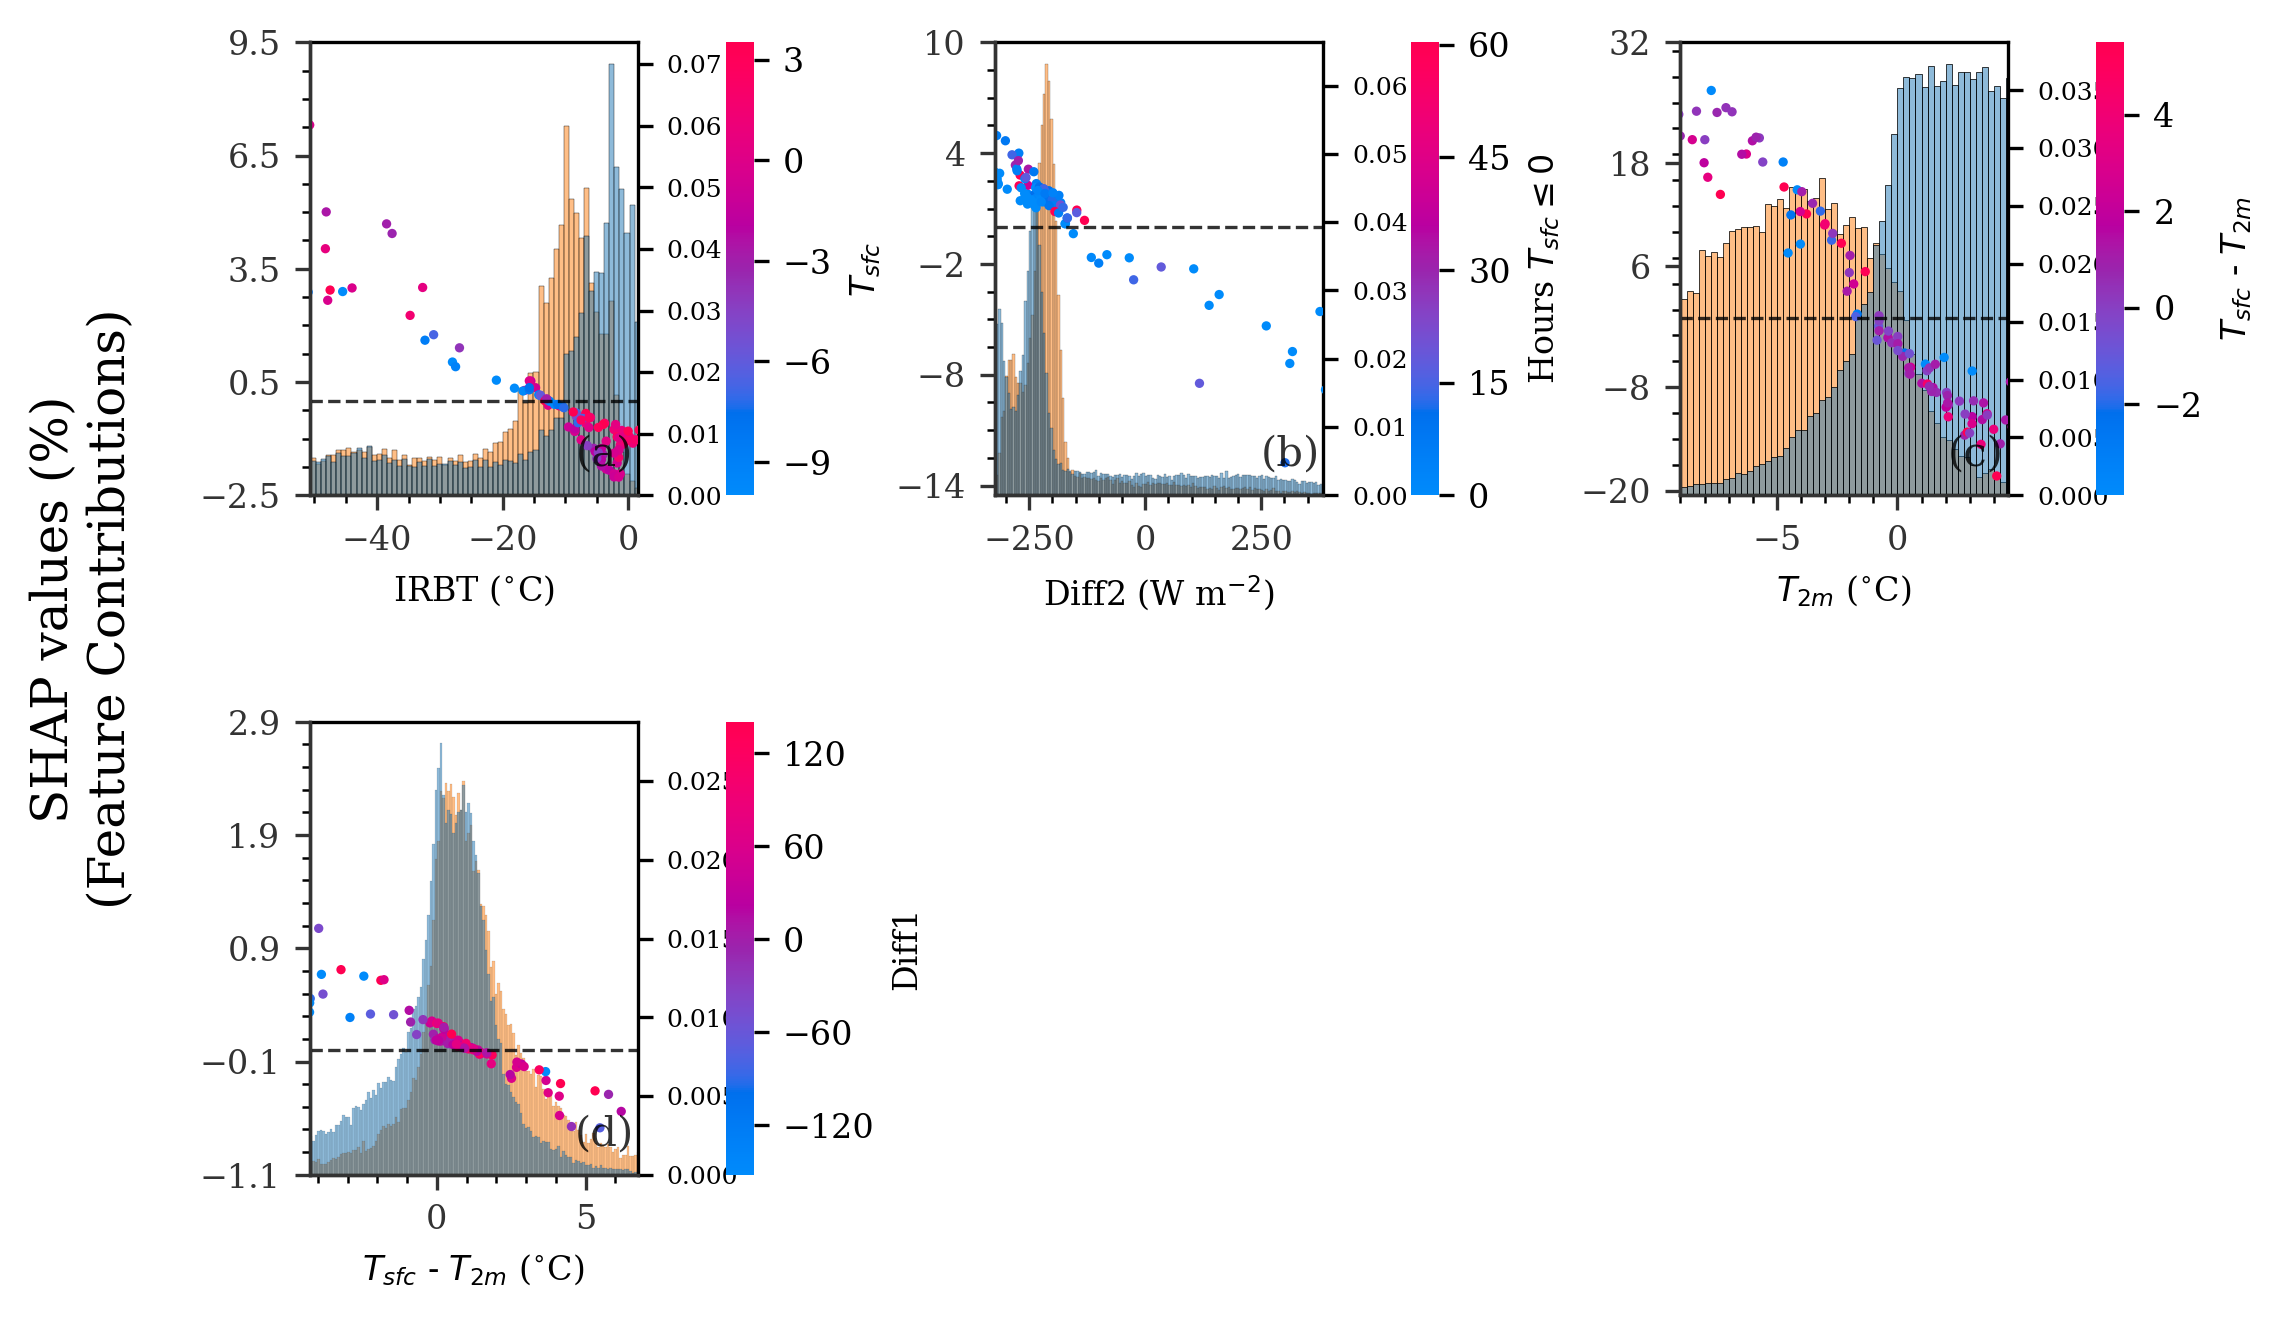

In [10]:
features = ['sat_irbt', 'd_rad_d', 'temp2m', 'hrrr_dT']

histdata=X.copy()
histdata['target'] = y

explainer.plot_shap(features=features,
                    plot_type = 'dependence',
                    shap_values=results,
                    estimator_name = 'Logistic Regression',
                    display_feature_names=plotting_config.display_feature_names,
                    display_units = plotting_config.display_units,
                    histdata=histdata,
                    target='target',
                    interaction_index='auto'
)

## No color-coding of dots 

Set `interaction_index=None` to remove the color-coding. 

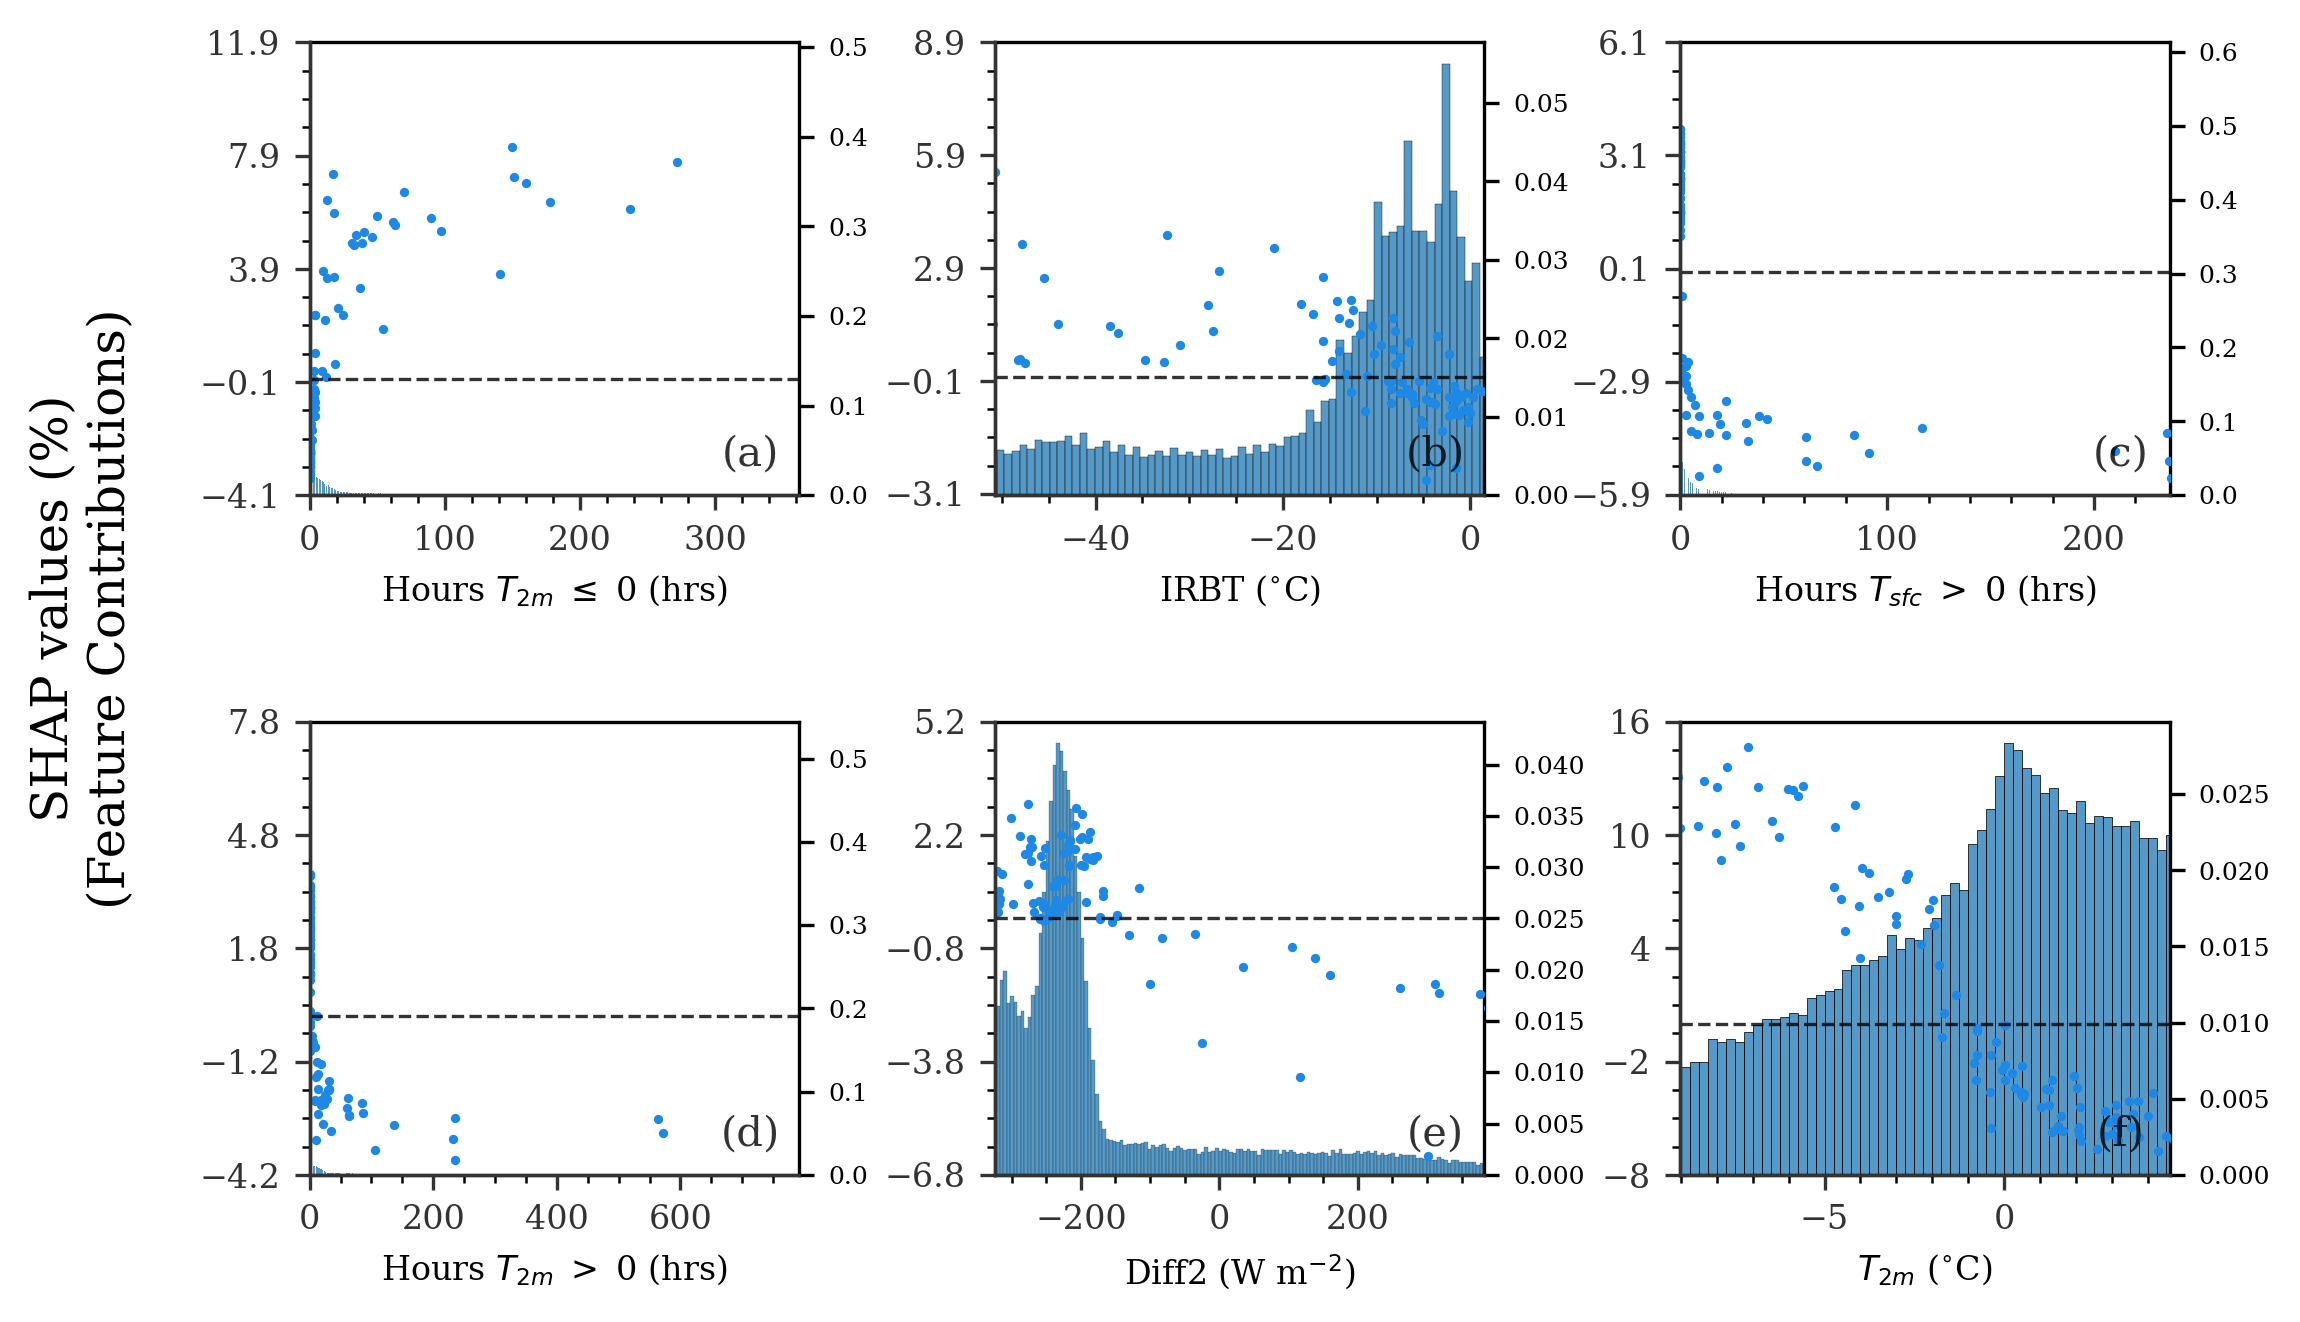

In [11]:
features = ['tmp2m_hrs_bl_frez', 'sat_irbt', 'sfcT_hrs_ab_frez', 'tmp2m_hrs_ab_frez', 'd_rad_d', 'temp2m']

explainer.plot_shap(features=features,
                    plot_type = 'dependence',
                    shap_values=shap_values,
                    estimator_name = 'Random Forest',
                    display_feature_names=plotting_config.display_feature_names,
                    display_units = plotting_config.display_units,
                    histdata=histdata,
                    interaction_index=None,
)

## Color-code the dots by the target value.

To color by the target values, set the target_values to y and keep `interaction_index=None`


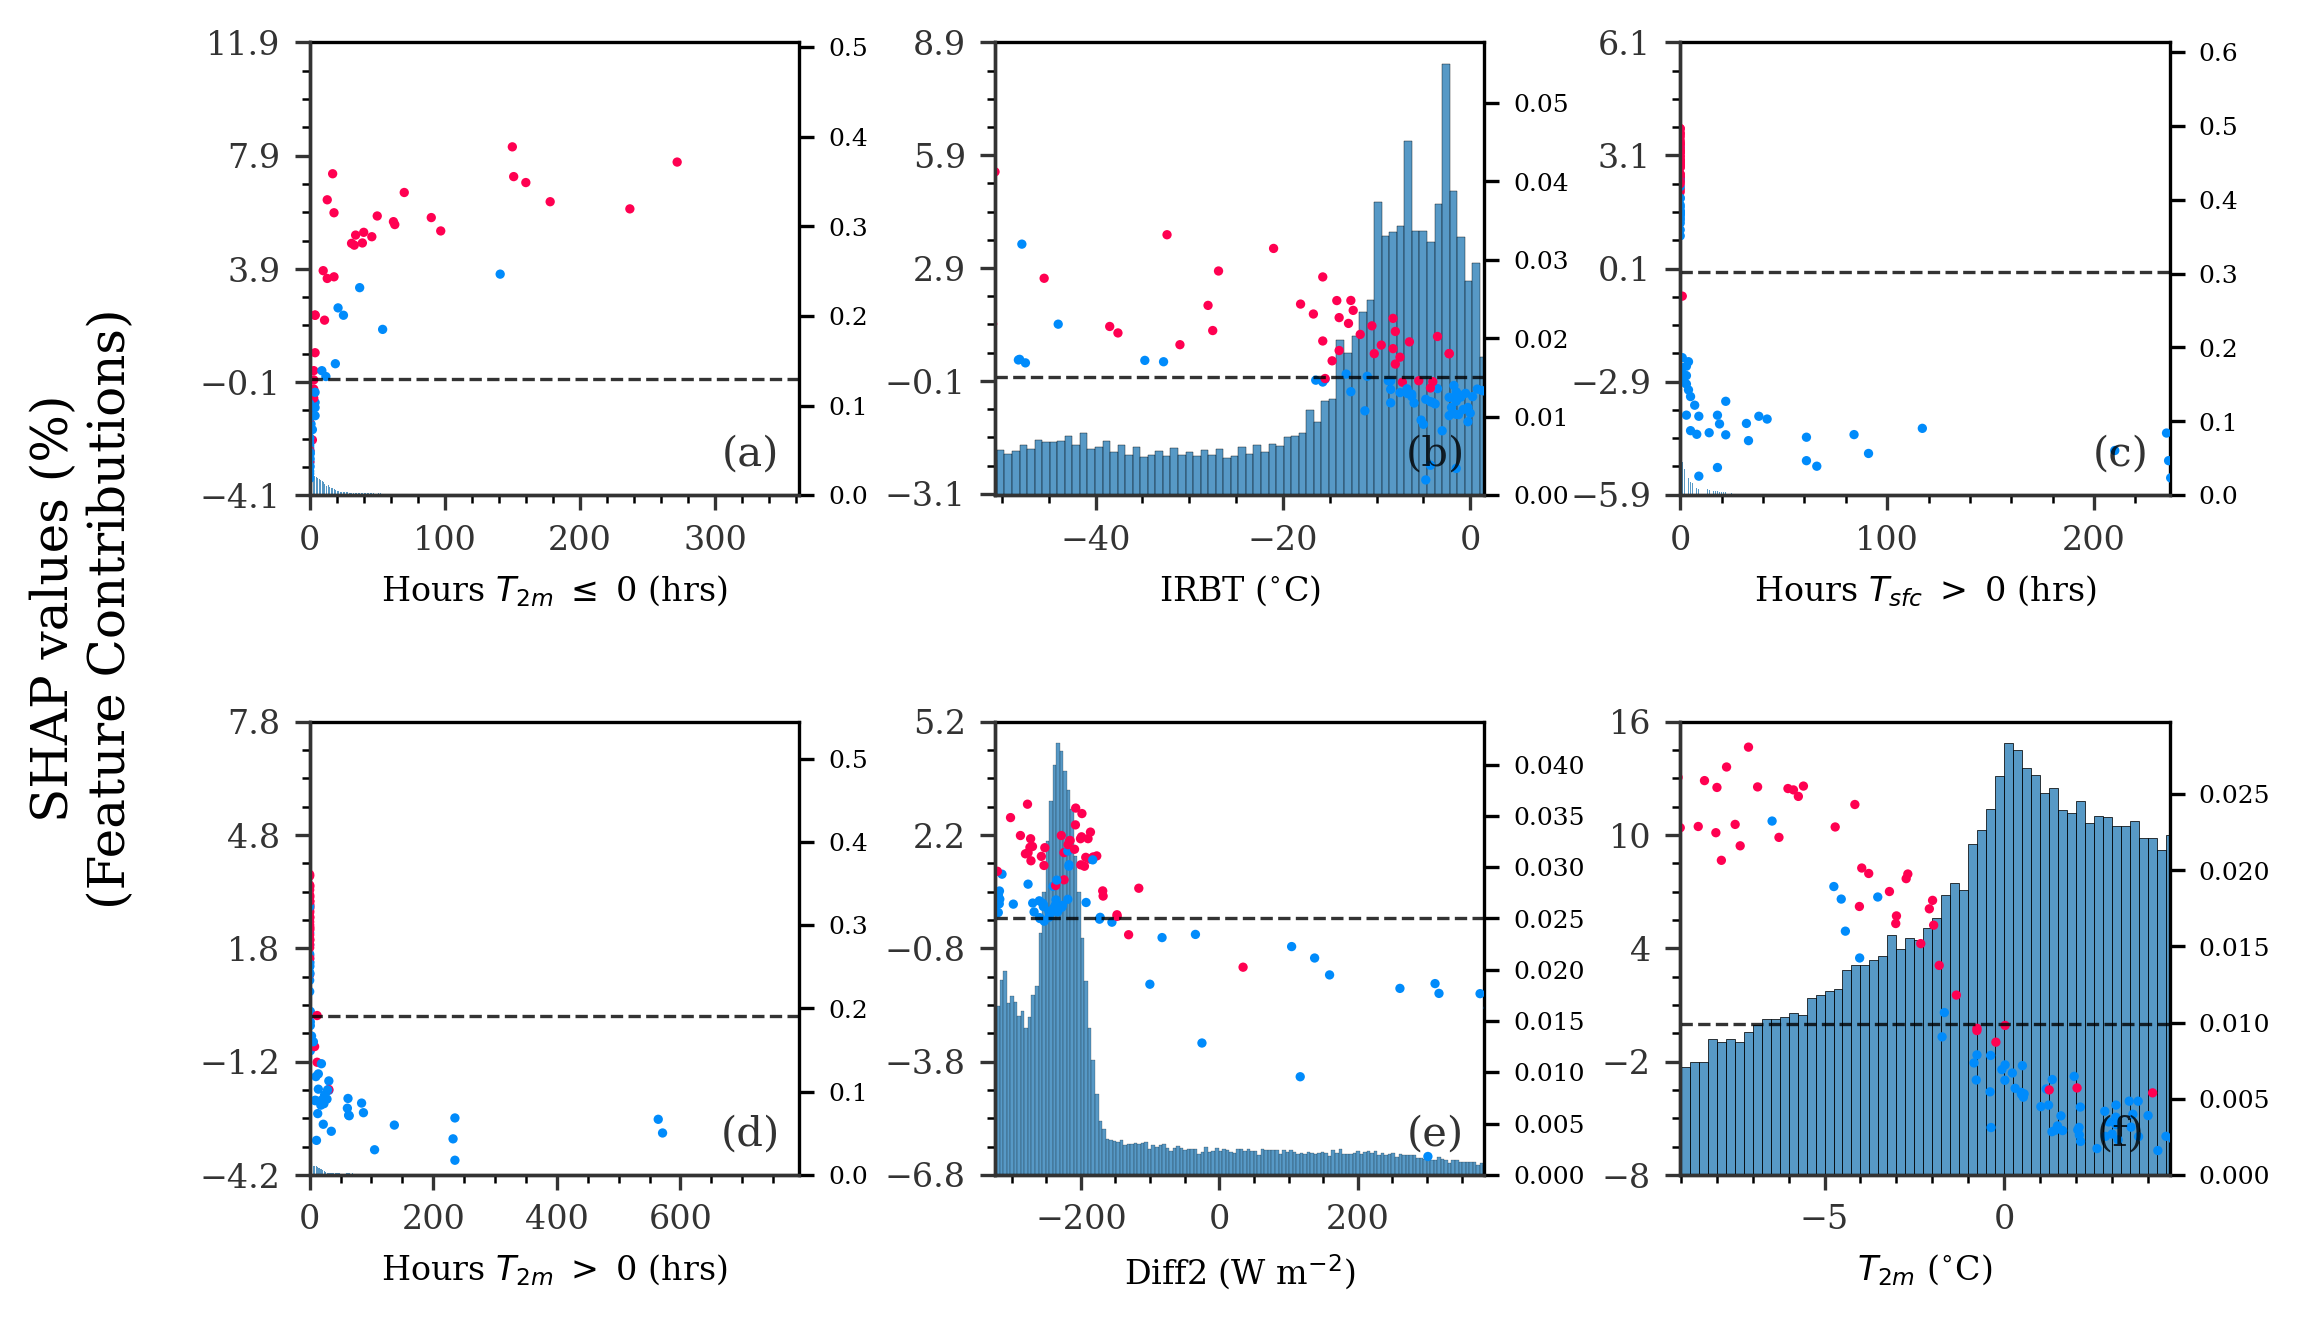

In [12]:
features = ['tmp2m_hrs_bl_frez', 'sat_irbt', 'sfcT_hrs_ab_frez', 'tmp2m_hrs_ab_frez', 'd_rad_d', 'temp2m']

explainer.plot_shap(features=features,
                    plot_type = 'dependence',
                    shap_values=shap_values,
                    estimator_name = 'Random Forest',
                    display_feature_names=plotting_config.display_feature_names,
                    display_units = plotting_config.display_units,
                    histdata=histdata,
                    target_values=y_subset, 
                    interaction_index=None,
)

## SHAP for Regression

In [13]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

In [14]:
data = fetch_california_housing()
X = data['data']
y = data['target']
feature_names = data['feature_names']
model= RandomForestRegressor()
model.fit(X,y)

RandomForestRegressor()

In [15]:
# X_subset is the set of examples we want to get SHAP values for.
random_state = np.random.RandomState(42)

ind = random_state.choice(len(X), size=100, replace=False)
X_subset = X[ind]
y_subset = y[ind]

In [23]:
explainer = skexplain.ExplainToolkit(('Random Forest', model), X=X_subset, feature_names=feature_names)

In [31]:
results = explainer.shap(shap_kwargs={
    'masker' : shap.maskers.Partition(X, max_samples=100, clustering='correlation'),
    'algorithm' : 'permutation'})

Permutation explainer: 101it [02:56,  1.88s/it]                                                                                                                                                                                                                                                                                                      


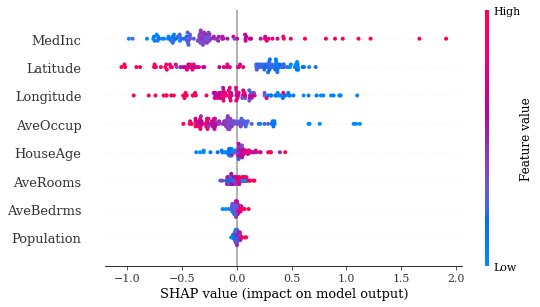

In [32]:
explainer.plot_shap(
                    plot_type = 'summary',
                    estimator_name = 'Random Forest',
                    shap_values=results,
                    display_feature_names=plotting_config.display_feature_names,
)                           